In [1]:
import nltk
import re
import pandas as pd
import numpy as np
import statsmodels
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn
import statsmodels.formula.api



# Glove

## Embeddings

In [3]:
def remove_from_list(word_list, not_in_embed):
    for i in not_in_embed:
        word_list.remove(i)
    return word_list


def load_embeddings(fn):
    labels = []
    rows = []
    with open(fn, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)

    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')


def load_lexicon(filename):
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [4]:
#download this file at: https://nlp.stanford.edu/projects/glove/
embeddings = load_embeddings('data/glove.42B.300d.txt')

In [50]:

print("shape", embeddings.shape)
embeddings.head()

shape (1917494, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
",",0.18378,-0.121230,-0.119870,0.015227,-0.191210,-0.066074,-2.9876,0.807950,0.067338,-0.131840,...,0.136150,0.109990,-0.334740,-0.046109,0.10780,-0.035657,-0.012921,-0.039038,0.182740,0.146540
the,-0.20838,-0.149320,-0.017528,-0.028432,-0.060104,-0.264600,-4.1445,0.629320,0.336720,-0.433950,...,-0.041244,-0.461820,0.027903,0.546570,-0.25894,0.395150,0.261440,-0.540660,0.211990,-0.009436
.,0.10876,0.002244,0.222130,-0.121020,-0.048959,0.018135,-3.8174,-0.032631,-0.625940,-0.518980,...,0.063131,-0.212300,-0.300880,-0.451610,0.26480,0.075971,-0.406880,-0.296960,0.159390,-0.149020
and,-0.09611,-0.257880,-0.358600,-0.328870,0.579500,-0.517740,-4.1582,-0.113710,-0.108480,-0.488850,...,0.477810,-0.021213,-0.212360,0.423740,0.14083,0.067498,-0.126750,-0.370300,-0.092774,0.390580
to,-0.24837,-0.454610,0.039227,-0.284220,-0.031852,0.263550,-4.6323,0.013890,-0.539280,-0.084454,...,0.082736,-0.624690,0.044267,0.606730,-0.12458,-0.154430,-0.163390,0.053097,0.154580,-0.380530


In [6]:
# download from here: http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar
positive_words = load_lexicon('data/positive-words.txt')
negative_words = load_lexicon('data/negative-words.txt')

In [7]:
len(negative_words)

4783

In [8]:
pos_not_in_emb = ['a+', 'achievible', 'amiabily', 'dead-cheap', 'deginified', 'ecenomical', 'err-free', 'exaltedly', 'exaltingly', 'excallent', 'eye-catch', 'fancinating', 'fecilitous', 'futurestic', 'heroize', 'invaluablely', 'jaw-droping', 'jollify', 'pamperedly', 'pamperedness', 'poeticize', 'prospros', 'raptureous', 'raptureously', 'rejoicingly', 'stellarly', 'supurbly', 'upliftingly', 'well-backlit']
neg_not_in_emb = ['2-faces', 'acridly', 'acridness', 'admonishingly', 'adulterier', 'asinininity', 'audiciously', 'back-wood', 'backaching', 'banalize', 'bulkyness', 'bull****', 'bull----', 'bullyingly', 'bumpping', 'burdensomely', 'calumniously', 'cataclysmal', 'concens', 'conscons', 'corruptted', 'coupists', 'craftly', 'cuplrit', 'd*mn', 'degenerately', 'degradingly', 'demoralizingly', 'denunciate', 'deploringly', 'depravedly', 'derisiveness', 'desititute', 'destains', 'discomfititure', 'disconsolation', 'discoutinous', 'disgustfully', 'dishonorablely', 'dismalness', 'disoobedient', 'disrespectablity', 'dissocial', 'dissonantly', 'distains', 'distraughtly', 'distraughtness', 'dizzing', 'dizzingly', 'downheartedly', 'election-rigger', 'exorbitantance', 'f**k', 'farcical-yet-provocative', 'fastuous', 'feeblely', 'flakieness', 'flicering', 'gainsayer', 'gimmicking', 'grumpish', 'hoodium', 'horrifys', 'ill-sorted', 'imposers', 'inadverent', 'inadverently', 'incapably', 'indeterminably', 'insociable', 'insupportably', 'inteferes', 'intolerablely', 'invidiousness', 'irksomenesses', 'irragularity', 'irrecoverableness', 'irrecoverablenesses', 'irreplacible', 'irretating', 'jutter', 'jutters', 'layoff-happy', 'lunaticism', 'martyrdom-seeking', 'misbecome', 'misbecoming', 'multi-polarization', 'over-awe', 'overzelous', 'perfidity', 'polemize', 'quarrellous', 'quarrellously', 'rantingly', 'repugn', 'revengefully', 'rremediable', 'scoldingly', 'self-coup', 'selfinterested', 'sh*t', 'sloooooooooooooow', 'slumpping', 'smuttier', 'spoilages', 'spoilled', 'terror-genic', 'tetchily', 'thumb-down', 'tin-y', 'tiringly', 'two-faces', 'ultra-hardline', 'un-viewable', 'unacceptablely', 'unbearablely', 'undependability', 'unintelligile', 'unlamentable', 'unlamentably', 'unprove', 'unproves', 'unproving', 'unspeakablely', 'unuseably', 'uproarous', 'uproarously', 'villianously', 'wripped', 'wripping']

In [9]:
#pos_words = positive_words
#neg_words = negative_words

pos_words = remove_from_list(positive_words, pos_not_in_emb)
neg_words = remove_from_list(negative_words, neg_not_in_emb )

In [10]:
pos_vectors_glove = embeddings.loc[pos_words].dropna()
neg_vectors_glove = embeddings.loc[neg_words].dropna()

In [11]:
vectors = pd.concat([pos_vectors_glove, neg_vectors_glove])
targets = np.array([1 for entry in pos_vectors_glove.index] + [-1 for entry in neg_vectors_glove.index])
labels = list(pos_vectors_glove.index) + list(neg_vectors_glove.index)

In [12]:
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [13]:
model = SGDClassifier(loss='log', random_state=0, max_iter=1000)
model.fit(train_vectors, train_targets)

SGDClassifier(loss='log', random_state=0)

In [44]:
accuracy = accuracy_score(model.predict(test_vectors), test_targets)
accuracy

0.9441930618401206

In [15]:
def vecs_to_sentiment(vecs, model):
    predictions = model.predict_log_proba(vecs)
    return predictions[:, 1] - predictions[:, 0]

def words_to_sentiment(words, embeddings, model):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs, model)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)



In [16]:
words_to_sentiment(test_labels, embeddings, model).head(20)

,sentiment
fidget,-10.523408
interrupt,-10.475247
staunchly,-0.187009
imaginary,-3.268410
taxing,-0.608206
world-famous,6.755397
low-cost,9.253170
disapointment,-9.399764
totalitarian,-13.588078
bellicose,-9.986888


In [17]:
TOKEN_RE = re.compile(r"\w.*?\b")

def text_to_sentiment(text, embeddings, model):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(tokens, embeddings,  model)
    return sentiments['sentiment'].mean()

In [18]:
text_to_sentiment("My name is Heather", embeddings, model)


1.364266357023753

In [19]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Ellen', 'Lauren', 'Peggy',  'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Theo',  'Jerome',
        'Leroy', 'Torrance', 'Darnell', 'Lamar', 'Lionel',
        'Tyree', 'Lamont', 'Malik', 'Terrence', 'Tyrone',
         'Marcellus', 'Wardell',
        'Ebony',
        'Jasmine',  'Tia', 'Latoya',
        'Yolanda',  'Yvette'
    ],

    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Jorge', 'Santiago',
        'Mateo',  'Alejandro', 'Samuel', 'Diego', 'Daniel',
         'Ana', 'Luisa', 'Elena', 'Isabella', 'Valentina',
         'Mariana', 'Victoria', 'Martina'
    ],

    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Syed', 'Samar', 'Ahmad' ,'Mariam',
        'Jana', 'Salma', 'Nour', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Yasmin'
    ]
}

In [20]:
def name_sentiment_table(embeddings, model):
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names, embeddings, model)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

In [21]:
name_sentiments = name_sentiment_table(embeddings, model)

In [22]:
name_sentiments

,sentiment,group
mohammed,0.891362,Arab/Muslim
omar,-3.215986,Arab/Muslim
ahmed,3.541073,Arab/Muslim
ali,3.098263,Arab/Muslim
youssef,1.961432,Arab/Muslim
...,...,...
colleen,0.607765,White
emily,5.639965,White
megan,1.936170,White
rachel,1.511845,White


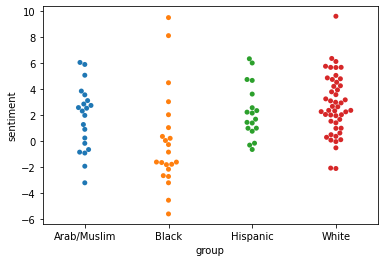

In [52]:
plot_glove = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)

In [24]:
ols_model = statsmodels.formula.api.ols('sentiment ~ group', data=name_sentiments).fit()
ols_model.summary().tables[0]


Dep. Variable:,sentiment,R-squared:,0.145
Model:,OLS,Adj. R-squared:,0.121
Method:,Least Squares,F-statistic:,5.934
Date:,"Mon, 22 Nov 2021",Prob (F-statistic):,0.000886
Time:,00:47:28,Log-Likelihood:,-258.49
No. Observations:,109,AIC:,525.0
Df Residuals:,105,BIC:,535.7
Df Model:,3,,
Covariance Type:,nonrobust,,


In [25]:
ols_model.fvalue

5.934485356749382

In [26]:
# Use a ConceptNet function to load word2vec into a Pandas frame from its binary format
from gensim.models import KeyedVectors
import os
from gensim.test.utils import datapath

#download googlenews embeddings from here: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
# uncomment this code for the word2vec embeddings

#w2v_model = KeyedVectors.load_word2vec_format(os.path.abspath(r'C:\Users\perni\Documents\NTNU\Racial Bias in Word Embeddings\data\GoogleNews-vectors-negative300.bin'), binary=True)
#w2v_model.save_word2vec_format('googlenews.txt')
# word2vec is case-sensitive, so case-fold its labels

# w2v

In [27]:
positive_words = load_lexicon('data/positive-words.txt')
negative_words = load_lexicon('data/negative-words.txt')



In [28]:
w2v = load_embeddings('googlenews.txt')

In [29]:
print(w2v.shape)
w2v.head()

(91738, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
</s>,0.001129,-0.000896,0.000319,0.001534,0.001106,-0.001404,-0.000031,-0.000420,-0.000576,0.001076,...,-0.001549,0.001373,-0.000061,-0.000824,0.001328,0.001160,0.000568,-0.001564,-0.000123,-0.000086
in,0.070312,0.086914,0.087891,0.062500,0.069336,-0.108887,-0.081543,-0.154297,0.020752,0.131836,...,-0.168945,-0.088867,-0.080566,0.064941,0.061279,-0.047363,-0.058838,-0.047607,0.014465,-0.062500
for,-0.011780,-0.047363,0.044678,0.063477,-0.018188,-0.063965,-0.001312,-0.072266,0.064453,0.086426,...,-0.022583,0.003723,-0.082520,0.081543,0.007935,0.000477,0.018433,0.071289,-0.034912,0.024170
that,-0.015747,-0.028320,0.083496,0.050293,-0.110352,0.031738,-0.014221,-0.089844,0.117676,0.118164,...,-0.011292,-0.015625,-0.033447,-0.020630,-0.019409,0.063965,0.020142,0.006866,0.061035,-0.148438
is,0.007050,-0.073242,0.171875,0.022583,-0.132812,0.198242,0.112793,-0.107910,0.071777,0.020874,...,-0.233398,-0.036377,-0.093750,0.182617,0.027100,0.127930,-0.024780,0.011230,0.164062,0.106934


In [30]:
w2v.index = [label.casefold() for label in w2v.index]

In [31]:
w2v = w2v.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')

In [32]:
w2v.shape

(78072, 300)

In [33]:
embeddings2 = w2v
remove_pos = ['a+', 'accessable', 'accomodative', 'achievible', 'admiringly', 'adorer', 'adoringly', 'adroit', 'adroitly', 'adulate', 'adulatory', 'advantageously', 'adventuresome', 'affability', 'affably', 'affectation', 'afordable', 'agilely', 'agreeableness', 'agreeably', 'all-around', 'alluringly', 'altruistically', 'amazes', 'ambitiously', 'amiability', 'amiabily', 'amicability', 'apotheosis', 'appreciatively', 'astonish', 'astound', 'astoundingly', 'astutely', 'attune', 'audibly', 'aver', 'awesomely', 'awsome', 'beauteous', 'beautifullly', 'believeable', 'beneficent', 'beneficially', 'benifits', 'best-known', 'best-performing', 'best-selling', 'better-known', 'better-than-expected', 'beutifully', 'blithe', 'brainiest', 'brand-new', 'breathlessness', 'breathtakingly', 'brilliances', 'cashbacks', 'cherub', 'chivalrous', 'chivalry', 'civilize', 'clear-cut', 'cohere', 'comely', 'commendably', 'commodious', 'compactly', 'conciliate', 'congratulation', 'contrasty', 'convience', 'convienient', 'convient', 'cost-effective', 'cost-saving', 'counter-attack', 'counter-attacks', 'courageousness', 'courtly', 'cure-all', 'cuteness', 'danke', 'danken', 'daringly', 'dauntless', 'dead-cheap', 'dead-on', 'deginified', 'delightfulness', 'dependably', 'dexterous', 'dexterously', 'dextrous', 'dignify', 'dirt-cheap', 'divinely', 'dote', 'dotingly', 'dreamland', 'dumbfounding', 'dummy-proof', 'easiness', 'easy-to-use', 'ebullience', 'ebulliently', 'ecenomical', 'ecstasies', 'ecstatically', 'edify', 'effectual', 'effusion', 'effusively', 'effusiveness', 'elate', 'elatedly', 'electrify', 'eminence', 'enchant', 'enchantingly', 'encouragingly', 'energy-efficient', 'energy-saving', 'enjoyably', 'ennoble', 'enrapt', 'enrapture', 'enraptured', 'enthral', 'enthrall', 'enthuse', 'enticingly', 'entrancing', 'enviably', 'enviously', 'enviousness', 'ergonomical', 'err-free', 'eulogize', 'euphorically', 'evaluative', 'exalt', 'exaltation', 'exaltedly', 'exalting', 'exaltingly', 'examplar', 'examplary', 'excallent', 'exceled', 'excelent', 'excellant', 'excellency', 'excitedness', 'excitingly', 'exellent', 'exemplar', 'exhilarate', 'exhilaratingly', 'extoll', 'exuberantly', 'exult', 'exultant', 'exultation', 'exultingly', 'eye-catch', 'eye-catching', 'eyecatch', 'eyecatching', 'fancinating', 'fascinatingly', 'fashionably', 'fast-growing', 'fast-paced', 'fastest-growing', 'favorited', 'favour', 'feasibly', 'feature-rich', 'fecilitous', 'felicitate', 'felicitous', 'fervid', 'fervidly', 'fine-looking', 'first-class', 'first-in-class', 'first-rate', 'flatteringly', 'fortuitously', 'ftw', 'futurestic', 'gaiety', 'gaily', 'gainful', 'gainfully', 'gallantly', 'geekier', 'gentlest', 'gladness', 'glimmering', 'glisten', 'glowingly', 'god-given', 'god-send', 'godlike', 'goodly', 'goood', 'gooood', 'gorgeously', 'graciousness', 'gratifies', 'gratify', 'gratifyingly', 'guiltless', 'halcyon', 'handier', 'hands-down', 'hard-working', 'hardier', 'hearten', 'heroize', 'heros', 'high-quality', 'high-spirited', 'hotcake', 'hotcakes', 'humour', 'humourous', 'idealize', 'idolize', 'illuminati', 'illumine', 'ilu', 'imaculate', 'immaculately', 'impressiveness', 'inestimable', 'inestimably', 'infallibility', 'infallibly', 'ingeniously', 'ingenuous', 'ingenuously', 'inpressed', 'insightfully', 'intelligible', 'intriguingly', 'invaluablely', 'inviolable', 'inviolate', 'invulnerable', 'irreproachable', 'irresistibly', 'issue-free', 'jaw-droping', 'jaw-dropping', 'jollify', 'joyously', 'jubilantly', 'jubilate', 'jubiliant', 'kid-friendly', 'kindliness', 'large-capacity', 'laudably', 'law-abiding', 'light-hearted', 'lionhearted', 'long-lasting', 'lovably', 'loveliness', 'low-cost', 'low-price', 'low-priced', 'low-risk', 'lower-priced', 'lucidly', 'luckiness', 'lustrous', 'luxuriant', 'luxuriate', 'luxuriously', 'magnanimously', 'maneuverable', 'marvelled', 'marvellous', 'marvelousness', 'matchless', 'maturely', 'merriness', 'mesmerize', 'mesmerizes', 'mesmerizingly', 'mind-blowing', 'miraculousness', 'monumentally', 'multi-purpose', 'neatest', 'nobly', 'noiseless', 'non-violence', 'non-violent', 'outstandingly', 'pain-free', 'painlessly', 'pamperedly', 'pamperedness', 'peaceable', 'pepped', 'pepping', 'peps', 'personages', 'pleasingly', 'pleasurably', 'plusses', 'poeticize', 'pre-eminent', 'prefered', 'preferes', 'prettily', 'problem-free', 'problem-solver', 'prodigiously', 'proficiently', 'profuse', 'propitious', 'propitiously', 'prospros', 'radiance', 'raptureous', 'raptureously', 'rapturous', 'rapturously', 'razor-sharp', 'realizable', 'recomend', 'record-setting', 'rectification', 'regally', 'rejoicingly', 'remunerate', 'resound', 'reverent', 'reverently', 'revolutionizes', 'rewardingly', 'righten', 'righteously', 'rightness', 'risk-free', 'rock-star', 'rock-stars', 'rockstars', 'romanticize', 'roomier', 'sagacity', 'sagely', 'saintliness', 'salutary', 'satisified', 'self-determination', 'self-respect', 'self-satisfaction', 'self-sufficiency', 'self-sufficient', 'shimmeringly', 'slammin', 'smilingly', 'smoothes', 'solicitous', 'solicitously', 'soothingly', 'spellbind', 'spellbindingly', 'state-of-the-art', 'statuesque', 'staunchness', 'steadiest', 'steadiness', 'stellarly', 'stirringly', 'stupendously', 'suavely', 'succes', 'sufficed', 'suffices', 'sumptuously', 'sumptuousness', 'supurb', 'supurbly', 'swankier', 'swankiest', 'swiftness', 'tantalize', 'tantalizingly', 'temptingly', 'tenaciously', 'tenderly', 'thrillingly', 'thumb-up', 'thumbs-up', 'time-honored', 'tingle', 'titillate', 'titillatingly', 'toll-free', 'top-notch', 'top-quality', 'topnotch', 'triumphal', 'trivially', 'trouble-free', 'trustingly', 'twinkly', 'ultra-crisp', 'unbound', 'undisputable', 'undisputably', 'upgradable', 'upliftingly', 'upliftment', 'user-friendly', 'user-replaceable', 'venerate', 'vibrantly', 'virtuously', 'vouchsafe', 'warmhearted', 'well-backlit', 'well-balanced', 'well-behaved', 'well-being', 'well-bred', 'well-connected', 'well-educated', 'well-established', 'well-informed', 'well-intentioned', 'well-known', 'well-made', 'well-managed', 'well-mannered', 'well-positioned', 'well-received', 'well-regarded', 'well-rounded', 'well-run', 'well-wishers', 'whooa', 'whoooa', 'wieldy', 'wonderous', 'wonderously', 'world-famous', 'worth-while', 'zippy']
remove_neg = ['2-faced', '2-faces', 'abominably', 'abominate', 'aborts', 'abrade', 'abscond', 'absent-minded', 'absurdness', 'abysmally', 'accost', 'accursed', 'accusingly', 'acerbate', 'acerbically', 'ached', 'achey', 'acrid', 'acridly', 'acridness', 'acrimoniously', 'admonisher', 'admonishingly', 'adulterate', 'adulteration', 'adulterier', 'afflictive', 'aggrieve', 'aggrivation', 'agonies', 'agonize', 'ail', 'anarchism', 'anarchistic', 'angriness', 'anti-', 'anti-american', 'anti-israeli', 'anti-occupation', 'anti-proliferation', 'anti-semites', 'anti-social', 'anti-us', 'anti-white', 'anxiousness', 'apathetically', 'appal', 'appall', 'appallingly', 'apprehensively', 'arduously', 'asininely', 'asinininity', 'askance', 'asperse', 'aspersion', 'aspersions', 'assail', 'assult', 'asunder', 'audaciously', 'audaciousness', 'audiciously', 'autocrat', 'avarice', 'avaricious', 'avariciously', 'aweful', 'awfulness', 'back-logged', 'back-wood', 'back-woods', 'backache', 'backaches', 'backaching', 'backbite', 'backbiting', 'backwood', 'bafflement', 'banalize', 'barbarically', 'barbarity', 'barbarous', 'barbarously', 'beastly', 'bedlamite', 'befoul', 'beggarly', 'beguile', 'belabor', 'beleaguer', 'belligerently', 'bereave', 'beseech', 'besiege', 'besmirch', 'bestial', 'betrayals', 'betrayer', 'bewail', 'bewilder', 'bewilderingly', 'bewitch', 'bid-rigging', 'bigotries', 'bitingly', 'blab', 'blabber', 'blameworthy', 'blandish', 'blaspheme', 'blather', 'bleakly', 'bleakness', 'blindingly', 'blockhead', 'blotchy', 'blundering', 'bluring', 'blurt', 'boggle', 'botch', 'bowdlerize', 'braggart', 'bragger', 'brainless', 'brainwash', 'brashly', 'brashness', 'brazenness', 'break-up', 'break-ups', 'brimstone', 'broken-hearted', 'browbeat', 'brusque', 'brutalising', 'brutalities', 'brutalize', 'brutalizing', 'bulkier', 'bulkiness', 'bulkyness', 'bull****', 'bull----', 'bullshyt', 'bullyingly', 'bumpping', 'bungle', 'bungler', 'burdensomely', 'busybody', 'butchery', 'cackle', 'calamitously', 'calumniate', 'calumniation', 'calumnies', 'calumnious', 'calumniously', 'calumny', 'cannibal', 'capriciously', 'capriciousness', 'cash-strapped', 'castigate', 'castrated', 'cataclysm', 'cataclysmal', 'cataclysmically', 'catastrophically', 'catastrophies', 'caustically', 'chafe', 'chasten', 'chastisement', 'chatterbox', 'cheapen', 'cheerless', 'chide', 'chintzy', 'choleric', 'clamorous', 'coldly', 'collude', 'combust', 'commiserate', 'commotions', 'conceited', 'concen', 'concens', 'condemnable', 'condescend', 'condescendingly', 'confusions', 'conscons', 'contaminates', 'contemptible', 'contemptuously', 'contort', 'contortions', 'contrariness', 'contrive', 'corrode', 'corrosions', 'corrupts', 'corruptted', 'counter-productive', 'coupists', 'covetous', 'crabby', 'craftily', 'craftly', 'cravenly', 'crazily', 'creak', 'creaks', 'credulous', 'cringes', 'cripples', 'crowdedness', 'crueler', 'cruelest', 'cruelness', 'cruelties', 'crumple', 'crumples', 'cunt', 'cunts', 'cuplrit', 'cuss', 'cussed', 'd*mn', 'damnable', 'damnably', 'damnation', 'dangerousness', 'dastard', 'daunt', 'dauntingly', 'dawdle', 'deadbeat', 'deadweight', 'debase', 'debasement', 'debaser', 'debauch', 'debaucher', 'debilitate', 'debility', 'deceitfully', 'deceitfulness', 'deceiver', 'deceivers', 'declaim', 'decrement', 'decrepitude', 'defamations', 'defile', 'defiler', 'deform', 'degenerately', 'degradingly', 'dehumanization', 'dehumanize', 'deign', 'deject', 'dejectedly', 'dejection', 'delude', 'demolisher', 'demonizes', 'demoralizingly', 'denunciate', 'deplorably', 'deploring', 'deploringly', 'deprave', 'depravedly', 'deprecate', 'depressingly', 'derisive', 'derisively', 'derisiveness', 'desecrate', 'desiccate', 'desiccated', 'desititute', 'desolately', 'despairingly', 'despicably', 'despoil', 'despoiler', 'despondence', 'despondency', 'despondently', 'despotism', 'destabilisation', 'destains', 'desultory', 'detestable', 'detestably', 'detesting', 'detests', 'detracted', 'detracting', 'detraction', 'devastates', 'devastatingly', 'devilishly', 'devilment', 'devilry', 'deviously', 'deviousness', 'diabolic', 'diabolically', 'diametrically', 'diappointed', 'diatribes', 'die-hard', 'diffidence', 'dilly-dally', 'dings', 'dinky', 'direly', 'direness', 'dirtbag', 'dirtbags', 'dirts', 'disaccord', 'disadvantageous', 'disaffect', 'disaffirm', 'disagreeably', 'disapointed', 'disapointing', 'disapointment', 'disapprobation', 'disasterous', 'disavowal', 'disbelieve', 'disbeliever', 'disclaim', 'discombobulate', 'discomfit', 'discomfititure', 'discompose', 'disconcert', 'disconcerted', 'disconcertingly', 'disconsolate', 'disconsolately', 'disconsolation', 'discontented', 'discontentedly', 'discontinuity', 'discontinuous', 'discordance', 'discordant', 'discountenance', 'discouragingly', 'discourteous', 'discourteously', 'discoutinous', 'discrepant', 'disdained', 'disdainful', 'disdainfully', 'disfavor', 'disgracefully', 'disgruntle', 'disgustedly', 'disgustful', 'disgustfully', 'disgustingly', 'dishearten', 'dishearteningly', 'dishonorablely', 'disillusion', 'disillusions', 'disinclination', 'disinclined', 'disingenuously', 'disintegrates', 'disliking', 'dismally', 'dismalness', 'dismaying', 'dismayingly', 'disobedient', 'disoobedient', 'disordered', 'disorient', 'disparagingly', 'dispensable', 'dispirit', 'dispiritedly', 'displease', 'displeasing', 'disputable', 'disquietingly', 'disquietude', 'disregardful', 'disreputable', 'disrespectable', 'disrespectablity', 'disrespectfully', 'disrespectfulness', 'dissapointed', 'dissappointed', 'dissappointing', 'dissatisfactory', 'dissatisfies', 'dissatisfy', 'dissatisfying', 'dissemble', 'dissembler', 'dissenter', 'dissention', 'disses', 'dissidence', 'dissocial', 'dissolute', 'dissonance', 'dissonant', 'dissonantly', 'dissuasive', 'distains', 'distastefully', 'distraughtly', 'distraughtness', 'distressingly', 'distrusting', 'disvalue', 'divisively', 'dizzing', 'dizzingly', 'doddering', 'dodgey', 'domineer', 'donside', 'doubtfully', 'douchbag', 'douchebag', 'douchebags', 'downfallen', 'downhearted', 'downheartedly', 'draconic', 'dragoon', 'dreadfully', 'dreadfulness', 'drippy', 'droop', 'droops', 'drop-out', 'drop-outs', 'drunkard', 'dubiously', 'dubitable', 'dullard', 'dumbfound', 'dunce', 'earsplitting', 'effrontery', 'egocentric', 'egomania', 'egotism', 'egotistically', 'egregiously', 'election-rigger', 'emasculate', 'embroil', 'embroilment', 'enervate', 'enfeeble', 'enflame', 'enjoin', 'enrage', 'enraging', 'enslave', 'entangle', 'entrap', 'enviously', 'enviousness', 'equivocal', 'evildoer', 'eviscerate', 'exagerate', 'exagerated', 'exagerates', 'exasperate', 'exasperatingly', 'excoriate', 'execrate', 'exhorbitant', 'exhort', 'exorbitantance', 'exorbitantly', 'expropriate', 'expulse', 'expunge', 'extravagantly', 'f**k', 'facetious', 'facetiously', 'fainthearted', 'faithless', 'fallacies', 'fallacious', 'fallaciously', 'fallaciousness', 'famished', 'fanatically', 'far-fetched', 'farcical-yet-provocative', 'farcically', 'fastidious', 'fastidiously', 'fastuous', 'fat-cat', 'fat-cats', 'fatalistic', 'fatalistically', 'fatcat', 'fatcats', 'fatefully', 'fathomless', 'fatique', 'fatuity', 'fatuous', 'fatuously', 'fawningly', 'fearfully', 'feeblely', 'feebleminded', 'feign', 'feint', 'felonious', 'fetid', 'fib', 'fibber', 'fidget', 'fidgety', 'fiend', 'fiendish', 'finagle', 'flabbergast', 'flagrantly', 'flairs', 'flakey', 'flakieness', 'flaking', 'flareup', 'flareups', 'flat-out', 'fleed', 'fleer', 'flicering', 'flickers', 'flighty', 'flimflam', 'fluster', 'forebodingly', 'forgetfully', 'forlornly', 'forswear', 'foully', 'foulness', 'fractiously', 'franticly', 'frazzle', 'freakishly', 'frenetically', 'fretful', 'frigging', 'frightfully', 'fruitlessly', 'full-blown', 'fulminate', 'fume', 'funnily', 'fustigate', 'fusty', 'futilely', 'gabble', 'gaff', 'gainsay', 'gainsayer', 'gallingly', 'galls', 'gape', 'gauche', 'gawky', 'geezer', 'get-rich', 'ghosting', 'gibber', 'gibe', 'gimmicked', 'gimmicking', 'glaringly', 'glibly', 'gloatingly', 'glower', 'goading', 'god-awful', 'goon', 'graceless', 'gracelessly', 'grievously', 'grouch', 'grouchy', 'gruesomely', 'grumpier', 'grumpiest', 'grumpily', 'grumpish', 'guiltily', 'hairloss', 'halfhearted', 'halfheartedly', 'hallucinate', 'hallucination', 'harangue', 'harasses', 'hard-hit', 'hard-line', 'hard-liner', 'hardheaded', 'hardhearted', 'harpy', 'harridan', 'hasseling', 'hatefully', 'hatefulness', 'haughtily', 'head-aches', 'heartbreakingly', 'heathen', 'heavy-handed', 'heavyhearted', 'heckle', 'heckles', 'heedless', 'hegemonism', 'hegemonistic', 'hell-bent', 'hellion', 'hells', 'heretic', 'hestitant', 'hideously', 'hideousness', 'high-priced', 'hiliarious', 'hissed', 'ho-hum', 'hoodium', 'hoodwink', 'hooligan', 'horrendously', 'horrifies', 'horrify', 'horrifys', 'hothead', 'hotheaded', 'hothouse', 'huckster', 'hurted', 'hypocricy', 'hypocritically', 'hysteric', 'hysterically', 'idiocies', 'idiotically', 'ignoble', 'ignominiously', 'ill-advised', 'ill-conceived', 'ill-defined', 'ill-designed', 'ill-fated', 'ill-favored', 'ill-formed', 'ill-mannered', 'ill-natured', 'ill-sorted', 'ill-tempered', 'ill-treated', 'ill-treatment', 'ill-usage', 'ill-used', 'illogic', 'illogically', 'imbecile', 'imminence', 'immoderate', 'immoderately', 'immodest', 'immorally', 'impatiently', 'impedance', 'impenitent', 'imperfection', 'imperfectly', 'imperiously', 'impertinent', 'impetuous', 'impetuously', 'impiety', 'impious', 'implacable', 'implausibly', 'impolite', 'impolitely', 'impolitic', 'importunate', 'importune', 'imposers', 'impossiblity', 'impoverish', 'imprecate', 'imprecisely', 'imprecision', 'improbability', 'imprudence', 'impudence', 'impudent', 'impudently', 'impugn', 'impulsively', 'impure', 'impurity', 'inadverent', 'inadverently', 'inadvisable', 'inadvisably', 'inanely', 'inapt', 'inaptitude', 'inarticulate', 'incapably', 'incautious', 'incivility', 'inclement', 'incognizant', 'incoherence', 'incoherently', 'incommensurate', 'incomparably', 'incompatability', 'incompetently', 'incompliant', 'incomprehension', 'inconceivably', 'incongruously', 'inconsequent', 'inconsequentially', 'inconsequently', 'inconsiderately', 'inconsistence', 'inconsolably', 'inconstant', 'inconveniently', 'incorrigible', 'incorrigibly', 'incredulously', 'indecently', 'indecisively', 'indecorum', 'indelicate', 'indeterminable', 'indeterminably', 'indignantly', 'indiscernible', 'indiscreet', 'indiscreetly', 'indiscriminating', 'indoctrinate', 'indolent', 'ineffectively', 'ineffectually', 'ineffectualness', 'inefficacious', 'inefficacy', 'inefficiently', 'inelegance', 'inelegant', 'ineloquent', 'ineloquently', 'ineptly', 'inequitably', 'inescapably', 'inessential', 'inexcusably', 'inexpert', 'inexpertly', 'inexpiable', 'inexplainable', 'inextricable', 'inextricably', 'inferiority', 'infernal', 'infest', 'infiltrator', 'inflammed', 'infuriatingly', 'inglorious', 'ingrate', 'ingratitude', 'inhospitality', 'inimically', 'iniquitous', 'iniquity', 'injudicious', 'inordinately', 'insensible', 'insensitively', 'insidiously', 'insignificance', 'insignificantly', 'insincerely', 'insincerity', 'insociable', 'insolence', 'insolent', 'insolently', 'insouciance', 'instable', 'instigators', 'insubordinate', 'insubstantial', 'insubstantially', 'insufferably', 'insufficiency', 'insultingly', 'insupportable', 'insupportably', 'insurmountably', 'intefere', 'inteferes', 'intimidatingly', 'intolerablely', 'intoxicate', 'invalidity', 'inveigle', 'invidious', 'invidiously', 'invidiousness', 'irascible', 'irately', 'irk', 'irking', 'irksome', 'irksomely', 'irksomeness', 'irksomenesses', 'ironical', 'irragularity', 'irrationalities', 'irrationality', 'irrationally', 'irrationals', 'irrecoverable', 'irrecoverableness', 'irrecoverablenesses', 'irrecoverably', 'irredeemable', 'irredeemably', 'irreformable', 'irreplacible', 'irresolute', 'irresolvable', 'irretating', 'irretrievable', 'irritably', 'irritations', 'jabber', 'jaundiced', 'jealously', 'jealousness', 'jeer', 'jeeringly', 'job-killing', 'judder', 'juddering', 'judders', 'junky', 'jutter', 'jutters', 'kaput', 'killjoy', 'knave', 'kook', 'lackeys', 'laggy', 'laid-off', 'lambast', 'lambaste', 'lame-duck', 'lamentably', 'languor', 'languorous', 'languorously', 'lascivious', 'last-ditch', 'lawbreaker', 'lawbreaking', 'layoff-happy', 'lech', 'lecher', 'lecherous', 'lechery', 'leer', 'left-leaning', 'less-developed', 'lesser-known', 'letch', 'lewdly', 'licentious', 'licentiously', 'licentiousness', 'lier', 'life-threatening', 'little-known', 'lividly', 'loathly', 'loathsomely', 'long-time', 'long-winded', 'longingly', 'lorn', 'lovelorn', 'low-rated', 'ludicrously', 'lugubrious', 'lunaticism', 'maddeningly', 'madder', 'maladjusted', 'maladjustment', 'malcontent', 'malcontented', 'maledict', 'malevolence', 'malevolently', 'maliciousness', 'malodorous', 'mangle', 'mangles', 'mangling', 'manipulators', 'martyrdom-seeking', 'mawkish', 'mawkishly', 'mawkishness', 'meanness', 'meddlesome', 'melodramatically', 'mendacious', 'mendacity', 'menial', 'miff', 'mindlessly', 'misalign', 'misaligned', 'misaligns', 'misapprehend', 'misbecome', 'misbecoming', 'misbegotten', 'miscalculate', 'mischievously', 'miscreant', 'miser', 'miserableness', 'misgiving', 'misguidance', 'misguide', 'mishandle', 'misinform', 'misjudge', 'misleadingly', 'mislike', 'mismanage', 'mispronounce', 'mispronounced', 'mispronounces', 'misstatement', 'mistified', 'mistrustful', 'mistrustfully', 'mists', 'mockeries', 'mockingly', 'monstrosities', 'monstrously', 'mope', 'morbidly', 'mordant', 'mordantly', 'mortification', 'mortify', 'mortifying', 'mourner', 'mournfully', 'mudslinger', 'mulish', 'multi-polarization', 'murderously', 'muscle-flexing', 'mystify', 'nastily', 'nauseate', 'nauseates', 'nauseatingly', 'nebulously', 'nefariously', 'negation', 'nettle', 'nettlesome', 'neurotically', 'niggle', 'nightmarishly', 'nitpick', 'nitpicking', 'noisier', 'non-confidence', 'nonresponsive', 'nosey', 'obnoxiously', 'obscenely', 'obsessiveness', 'obstinately', 'obstructs', 'obtrusive', 'occlude', 'occluded', 'occludes', 'occluding', 'odder', 'offence', 'offensiveness', 'officious', 'one-sided', 'onerously', 'oppressively', 'oppressiveness', 'ostracize', 'outrageousness', 'over-acted', 'over-awe', 'over-balanced', 'over-hyped', 'over-priced', 'over-valuation', 'overact', 'overacted', 'overawe', 'overbalance', 'overbalanced', 'overbearingly', 'overemphasize', 'overpayed', 'overplay', 'oversights', 'oversimplification', 'oversimplified', 'oversimplify', 'overstatements', 'overstates', 'overthrows', 'overzealously', 'overzelous', 'painfull', 'panders', 'panick', 'paralize', 'partiality', 'passe', 'passiveness', 'pauper', 'paupers', 'pedantic', 'peeve', 'peevish', 'peevishly', 'perfidious', 'perfidity', 'perilously', 'perplex', 'perplexity', 'pertinacious', 'pertinaciously', 'pertinacity', 'perturb', 'perversity', 'pessimistically', 'pestilent', 'petrify', 'pettifog', 'phobic', 'pillory', 'pimple', 'pitiable', 'pitifully', 'pitiless', 'pitilessly', 'plagiarize', 'plasticky', 'plaything', 'plebeian', 'plunderer', 'pointlessly', 'poisonously', 'pokey', 'poky', 'polarisation', 'polemize', 'polution', 'prate', 'pratfall', 'prattle', 'preoccupy', 'preposterously', 'presumptuously', 'pretence', 'pretentiously', 'prevaricate', 'prickle', 'prickles', 'prideful', 'prik', 'procrastinates', 'prohibitively', 'propagandize', 'pugnaciously', 'pugnacity', 'puzzlement', 'quack', 'qualm', 'quarrellous', 'quarrellously', 'quarrelsome', 'quibbles', 'rankle', 'rantingly', 'rascal', 'rascals', 'recourses', 'refutation', 'regreted', 'regretfully', 'relentlessness', 'remorsefully', 'remorseless', 'remorselessly', 'remorselessness', 'reprehensibly', 'reprehension', 'reprehensive', 'reproachful', 'reprove', 'reprovingly', 'repugn', 'repugnance', 'repugnantly', 'repulse', 'repulsing', 'repulsively', 'repulsiveness', 'retardedness', 'retards', 'revengeful', 'revengefully', 'revile', 'revoltingly', 'revulsive', 'rhapsodize', 'ricer', 'ridicules', 'rigidness', 'rip-off', 'ripoff', 'rremediable', 'ruffian', 'rumple', 'run-down', 'rusts', 'sadden', 'saggy', 'sags', 'sanctimonious', 'sardonically', 'satirize', 'scaly', 'scandalize', 'scandalously', 'scandel', 'scandels', 'scarily', 'scathingly', 'sceptical', 'scoffingly', 'scoldingly', 'scorchingly', 'scornful', 'scornfully', 'scoundrel', 'screw-up', 'screwed-up', 'screwy', 'scuff', 'scuffs', 'scummy', 'second-class', 'second-tier', 'seethe', 'self-coup', 'self-criticism', 'self-defeating', 'self-destructive', 'self-humiliation', 'self-interest', 'self-interested', 'self-serving', 'selfinterested', 'semi-retarded', 'senile', 'sensationalize', 'senselessly', 'sermonize', 'set-up', 'sh*t', 'shamefulness', 'shamelessness', 'shemale', 'shimmy', 'shirker', 'short-lived', 'shortchange', 'shortsightedness', 'shrew', 'shrilly', 'shrivel', 'sicken', 'sickeningly', 'sillily', 'simplistically', 'sinfully', 'sinisterly', 'skeptically', 'skittishly', 'skulk', 'slanderer', 'slanderously', 'slanders', 'slogs', 'sloooooooooooooow', 'sloooow', 'slooow', 'sloow', 'sloppily', 'slothful', 'slow-moving', 'sloww', 'slowww', 'slowwww', 'slumpping', 'sluts', 'smolder', 'smoulder', 'smouldering', 'smudged', 'smudges', 'smudging', 'smugly', 'smut', 'smuttier', 'smuttiest', 'smutty', 'snappish', 'snappishly', 'sneakily', 'sneeringly', 'snobbish', 'snobby', 'snobish', 'so-cal', 'soapy', 'solicitude', 'sorrowfully', 'sourly', 'spendy', 'spinster', 'spiritless', 'spitefully', 'spitefulness', 'splatter', 'spoilage', 'spoilages', 'spoilled', 'spookier', 'spookiest', 'spookily', 'spoon-fed', 'spoon-feed', 'spoonfed', 'squeaks', 'squeaky', 'stammer', 'startle', 'stereotypically', 'stiflingly', 'stingingly', 'straggle', 'straggler', 'stressfully', 'stridently', 'stringently', 'stupidest', 'stupified', 'stupify', 'stutters', 'sty', 'sub-par', 'subjection', 'subjugate', 'subservience', 'subversively', 'sucky', 'sueing', 'sugar-coat', 'sugar-coated', 'sugarcoated', 'sunder', 'superficiality', 'tarnishes', 'tauntingly', 'teasingly', 'tediously', 'tenuously', 'terribleness', 'terror-genic', 'testily', 'tetchily', 'tetchy', 'thoughtlessly', 'thoughtlessness', 'throb', 'throbbed', 'throbs', 'thumb-down', 'thumbs-down', 'time-consuming', 'timidly', 'timidness', 'tin-y', 'tingled', 'tiringly', 'top-heavy', 'torturously', 'traduce', 'traitorous', 'traitorously', 'transgress', 'traped', 'traumatically', 'traumatize', 'travesties', 'treacherously', 'treasonous', 'trivialize', 'troublesomely', 'troublingly', 'two-faced', 'two-faces', 'tyrannically', 'ulterior', 'ultimatums', 'ultra-hardline', 'un-viewable', 'unacceptablely', 'unaccessible', 'unachievable', 'unauthentic', 'unavoidably', 'unbearablely', 'uncivil', 'uncollectible', 'uncomfy', 'uncompromisingly', 'unconvincingly', 'uncouth', 'uncreative', 'undependability', 'undependable', 'underpowered', 'undissolved', 'uneasily', 'uneconomical', 'unfaithfully', 'unfeeling', 'ungovernable', 'unhappily', 'unimaginably', 'unintelligile', 'unipolar', 'unjustifiably', 'unkindly', 'unlamentable', 'unlamentably', 'unlawfulness', 'unnaturally', 'unnerve', 'unnervingly', 'unobserved', 'unorthodoxy', 'unpleasantries', 'unprove', 'unproved', 'unproves', 'unproving', 'unrelentingly', 'unreliability', 'unscrupulously', 'unsecure', 'unsettlingly', 'unspeakablely', 'unsteadily', 'unsteadiness', 'unsupportive', 'unthinkably', 'unusably', 'unuseable', 'unuseably', 'unviewable', 'unwatchable', 'unwillingly', 'upbraid', 'uproarious', 'uproariously', 'uproarous', 'uproarously', 'upseting', 'upsettingly', 'usurper', 'vagrant', 'vainly', 'vengefully', 'vengefulness', 'venomously', 'vex', 'vexation', 'vexingly', 'vibrated', 'vibrates', 'viciousness', 'vileness', 'villainously', 'villian', 'villianous', 'villianously', 'villify', 'vindictively', 'vindictiveness', 'virulence', 'virulently', 'vomits', 'wack', 'war-like', 'warlike', 'washed-out', 'wastefulness', 'water-down', 'watered-down', 'wearisome', 'wheedle', 'wickedly', 'woebegone', 'worriedly', 'worrier', 'worthlessly', 'worthlessness', 'wreaks', 'wretch', 'wretchedly', 'wretchedness', 'wrip', 'wripped', 'wripping', 'writhe', 'zaps', 'zealot', 'zealously']

In [34]:
neg_words2 =  remove_from_list(negative_words, remove_neg)
pos_words2 = remove_from_list(positive_words, remove_pos)

In [35]:
pos_vectors2 = embeddings2.loc[pos_words2].dropna()
neg_vectors2 = embeddings2.loc[neg_words2].dropna()

In [36]:
vectors2 = pd.concat([pos_vectors2, neg_vectors2])
targets2 = np.array([1 for entry in pos_vectors2.index] + [-1 for entry in neg_vectors2.index])
labels2 = list(pos_vectors2.index) + list(neg_vectors2.index)

In [37]:
train_vectors2, test_vectors2, train_targets2, test_targets2, train_labels2, test_labels2 = \
        train_test_split(vectors2, targets2, labels2, test_size=0.1, random_state=0)

In [38]:
model2 = SGDClassifier(loss='log', random_state=0)
model2.fit(train_vectors2, train_targets2)

SGDClassifier(loss='log', random_state=0)

In [39]:
accuracy2 = accuracy_score(model2.predict(test_vectors2), test_targets2)
print("Accuracy of sentiment: {:.2%}".format(accuracy2))

Accuracy of sentiment: 95.87%


F-value of bias: 12.543
Probability given null hypothesis: 4.5e-07


(-10.0, 10.0)

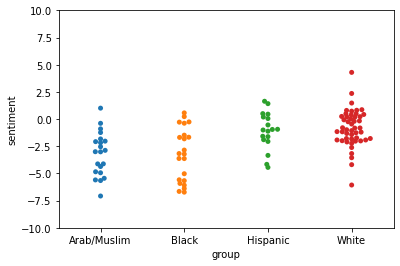

In [51]:
name_sentiments2 = name_sentiment_table(embeddings2, model2)
ols_model2 = statsmodels.formula.api.ols('sentiment ~ group', data=name_sentiments2).fit()
print("F-value of bias: {:.3f}".format(ols_model2.fvalue))
print("Probability given null hypothesis: {:.3}".format(ols_model2.f_pvalue))

# Show the results on a swarm plot, with a consistent Y-axis
plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments2)
plot.set_ylim([-10, 10])



<BarContainer object of 2 artists>

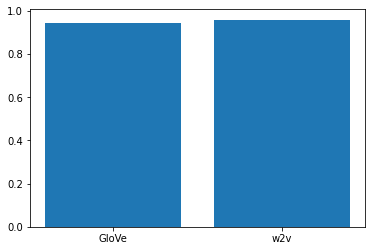

In [42]:
names = ['GloVe', "w2v"]
values = [accuracy, accuracy2]

plt.bar(names, values)




In [43]:
# With restaurant data